## SPWB, Traditional, and Baseline Pruning Experiment on CIFAR-10 using ResNet18

In [2]:
pip install torchvision scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



## 1. Dataset Preparation

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


## 2. Model Definition

In [5]:
def get_resnet18(num_classes=10):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

## 구조를 줄인 MiniResNet

In [ ]:
class MiniResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [ ]:
class MicroResNet18(nn.Module):  # SPWB용 더 작은 구조
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

## 3. Traditional Pruning

In [6]:
def apply_traditional_pruning(model, amount=0.5):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
    return model

## 4. SPWB Implementation

In [7]:
def apply_spwb(model, current_epoch, total_epochs, p=1.5, init_epoch=5, knee_epoch=60):
    alpha = 1.0 - max(min((current_epoch - init_epoch) / (knee_epoch), 1.0), 0.0)
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            weight = module.weight.data
            threshold = torch.quantile(weight.abs().flatten(), 0.5)  # prune 50% by default
            mask = weight.abs() < threshold
            weight[mask] = alpha ** p * weight[mask]

## 5. Training Loop with optional SPWB support

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, pruning_func=None):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if pruning_func:
                pruning_func(model, epoch)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct / total)

        print(f"[Epoch {epoch+1}] Train Loss: {train_losses[-1]:.4f}, Val Acc: {val_accs[-1]*100:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

## 6. Evaluation

In [9]:
def evaluate_model(model, test_loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())
    print(classification_report(trues, preds, digits=4))
    return accuracy_score(trues, preds), precision_score(trues, preds, average='macro'), recall_score(trues, preds, average='macro'), f1_score(trues, preds, average='macro')


## 7. Parameter Count

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 8. Plotting

In [11]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc, label):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss, label=f'{label} - Train Loss')
    plt.plot(val_loss, label=f'{label} - Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.subplot(1,2,2)
    plt.plot(train_acc, label=f'{label} - Train Acc')
    plt.plot(val_acc, label=f'{label} - Val Acc')
    plt.legend()
    plt.title("Accuracy")
    plt.show()

## 9. Experiment Execution

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


--- Training: Baseline ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1] Train Loss: 1.5050, Val Acc: 55.53%
[Epoch 2] Train Loss: 1.0753, Val Acc: 61.80%
[Epoch 3] Train Loss: 0.8640, Val Acc: 67.09%
[Epoch 4] Train Loss: 0.7168, Val Acc: 67.36%
[Epoch 5] Train Loss: 0.5949, Val Acc: 68.71%
[Epoch 6] Train Loss: 0.4803, Val Acc: 69.58%
[Epoch 7] Train Loss: 0.3902, Val Acc: 70.29%
[Epoch 8] Train Loss: 0.3126, Val Acc: 70.25%
[Epoch 9] Train Loss: 0.2479, Val Acc: 68.80%
[Epoch 10] Train Loss: 0.2125, Val Acc: 70.97%
[Epoch 11] Train Loss: 0.1611, Val Acc: 70.75%
[Epoch 12] Train Loss: 0.1475, Val Acc: 71.25%
[Epoch 13] Train Loss: 0.1133, Val Acc: 70.77%
[Epoch 14] Train Loss: 0.1055, Val Acc: 71.36%
[Epoch 15] Train Loss: 0.0827, Val Acc: 72.10%
[Epoch 16] Train Loss: 0.0752, Val Acc: 71.61%
[Epoch 17] Train Loss: 0.0619, Val Acc: 71.40%
[Epoch 18] Train Loss: 0.0663, Val Acc: 72.09%
[Epoch 19] Train Loss: 0.0495, Val Acc: 72.69%
[Epoch 20] Train Loss: 0.0527, Val Acc: 73.12%


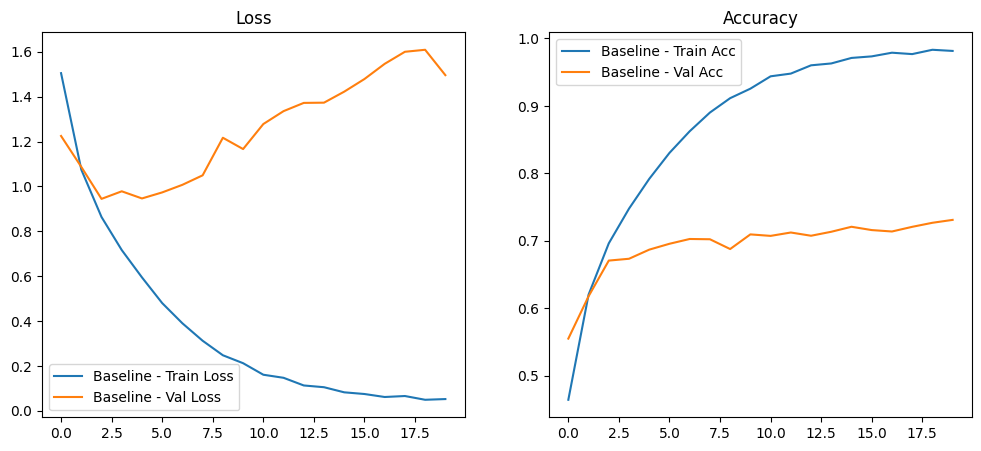

              precision    recall  f1-score   support

           0     0.7600    0.8170    0.7875      1000
           1     0.8248    0.8240    0.8244      1000
           2     0.6594    0.6390    0.6491      1000
           3     0.5509    0.5570    0.5540      1000
           4     0.7083    0.6580    0.6822      1000
           5     0.5873    0.6660    0.6242      1000
           6     0.7975    0.7800    0.7887      1000
           7     0.7907    0.7780    0.7843      1000
           8     0.8739    0.8110    0.8413      1000
           9     0.7875    0.7820    0.7847      1000

    accuracy                         0.7312     10000
   macro avg     0.7340    0.7312    0.7320     10000
weighted avg     0.7340    0.7312    0.7320     10000


--- Training: Traditional ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1] Train Loss: 1.5878, Val Acc: 49.24%
[Epoch 2] Train Loss: 1.1521, Val Acc: 58.24%
[Epoch 3] Train Loss: 0.9379, Val Acc: 61.82%
[Epoch 4] Train Loss: 0.7784, Val Acc: 66.18%
[Epoch 5] Train Loss: 0.6530, Val Acc: 66.57%
[Epoch 6] Train Loss: 0.5395, Val Acc: 67.16%
[Epoch 7] Train Loss: 0.4538, Val Acc: 68.89%
[Epoch 8] Train Loss: 0.3609, Val Acc: 68.34%
[Epoch 9] Train Loss: 0.3049, Val Acc: 67.48%
[Epoch 10] Train Loss: 0.2601, Val Acc: 67.33%
[Epoch 11] Train Loss: 0.2102, Val Acc: 68.41%
[Epoch 12] Train Loss: 0.1727, Val Acc: 68.63%
[Epoch 13] Train Loss: 0.1453, Val Acc: 69.05%
[Epoch 14] Train Loss: 0.1222, Val Acc: 68.55%
[Epoch 15] Train Loss: 0.1164, Val Acc: 68.96%
[Epoch 16] Train Loss: 0.1000, Val Acc: 69.40%
[Epoch 17] Train Loss: 0.0937, Val Acc: 68.97%
[Epoch 18] Train Loss: 0.0664, Val Acc: 69.42%
[Epoch 19] Train Loss: 0.0748, Val Acc: 70.30%
[Epoch 20] Train Loss: 0.0656, Val Acc: 69.89%


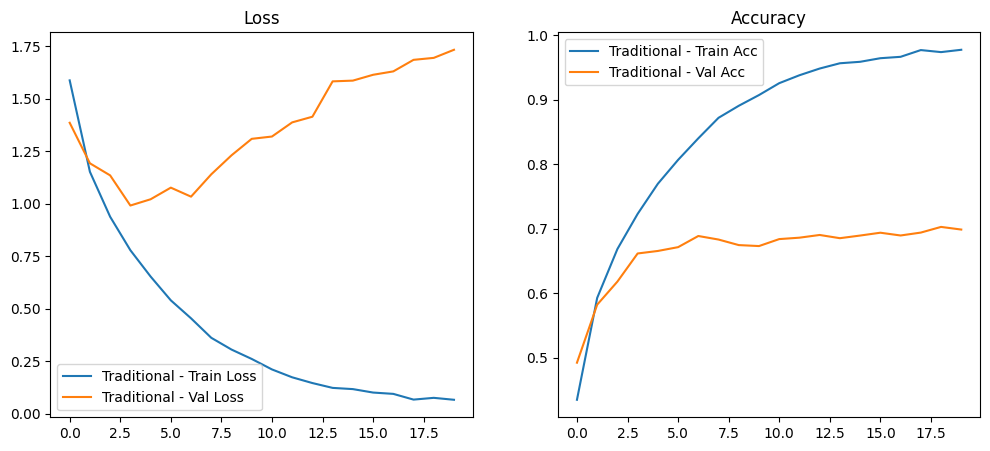

              precision    recall  f1-score   support

           0     0.7565    0.7240    0.7399      1000
           1     0.8462    0.7430    0.7913      1000
           2     0.6439    0.5950    0.6185      1000
           3     0.5256    0.4730    0.4979      1000
           4     0.5986    0.7070    0.6483      1000
           5     0.6098    0.6000    0.6048      1000
           6     0.7729    0.7420    0.7571      1000
           7     0.7417    0.7580    0.7498      1000
           8     0.8035    0.8300    0.8165      1000
           9     0.7037    0.8170    0.7561      1000

    accuracy                         0.6989     10000
   macro avg     0.7002    0.6989    0.6980     10000
weighted avg     0.7002    0.6989    0.6980     10000


--- Training: SPWB ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1] Train Loss: 1.5147, Val Acc: 55.71%
[Epoch 2] Train Loss: 1.0909, Val Acc: 60.39%
[Epoch 3] Train Loss: 0.8853, Val Acc: 65.00%
[Epoch 4] Train Loss: 0.7219, Val Acc: 68.86%
[Epoch 5] Train Loss: 0.6100, Val Acc: 68.58%
[Epoch 6] Train Loss: 0.4949, Val Acc: 69.88%
[Epoch 7] Train Loss: 0.4508, Val Acc: 69.79%
[Epoch 8] Train Loss: 0.3110, Val Acc: 70.65%
[Epoch 9] Train Loss: 0.2225, Val Acc: 70.08%
[Epoch 10] Train Loss: 0.1651, Val Acc: 70.67%
[Epoch 11] Train Loss: 0.1279, Val Acc: 71.07%
[Epoch 12] Train Loss: 0.1109, Val Acc: 70.48%
[Epoch 13] Train Loss: 0.0919, Val Acc: 71.80%
[Epoch 14] Train Loss: 0.0855, Val Acc: 71.45%
[Epoch 15] Train Loss: 0.0708, Val Acc: 71.94%
[Epoch 16] Train Loss: 0.0596, Val Acc: 71.09%
[Epoch 17] Train Loss: 0.0544, Val Acc: 71.52%
[Epoch 18] Train Loss: 0.0484, Val Acc: 72.15%
[Epoch 19] Train Loss: 0.0458, Val Acc: 71.75%
[Epoch 20] Train Loss: 0.0448, Val Acc: 72.12%


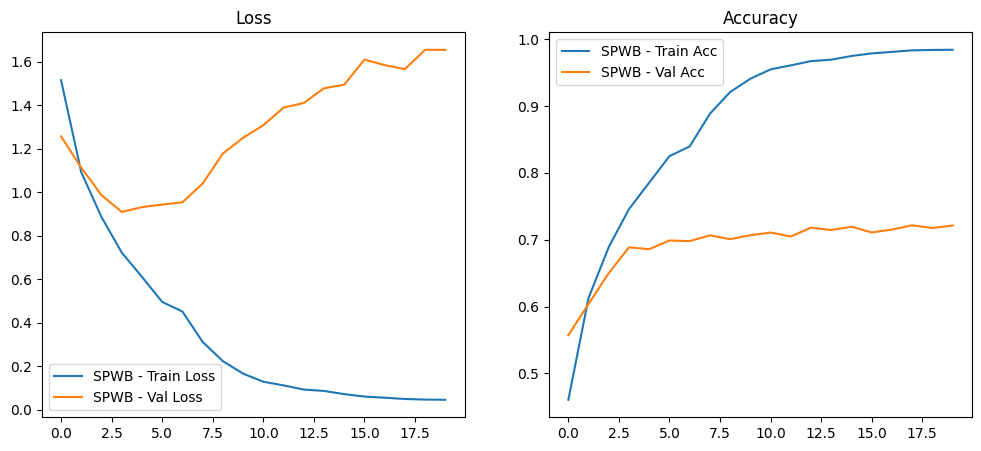

              precision    recall  f1-score   support

           0     0.7654    0.7700    0.7677      1000
           1     0.8002    0.8490    0.8239      1000
           2     0.6787    0.5830    0.6272      1000
           3     0.5457    0.5490    0.5474      1000
           4     0.6805    0.6900    0.6852      1000
           5     0.5734    0.6330    0.6017      1000
           6     0.7339    0.8000    0.7656      1000
           7     0.7883    0.7710    0.7796      1000
           8     0.8359    0.8250    0.8304      1000
           9     0.8291    0.7420    0.7831      1000

    accuracy                         0.7212     10000
   macro avg     0.7231    0.7212    0.7212     10000
weighted avg     0.7231    0.7212    0.7212     10000



In [ ]:
results = []

for name, model_func, prune_func in [
    ("Baseline", get_resnet18, None),  # ResNet18 사용 (원본)
    ("Traditional", MiniResNet18, lambda model, epoch: apply_traditional_pruning(model, 0.5)),  # 구조 축소 + Hard Pruning
    ("SPWB", MiniResNet18, lambda model, epoch: apply_spwb(model, epoch, 80))  # 구조 축소 + SPWB 방식
]:
    print(f"\n--- Training: {name} ---")
    model = model_func().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    tl, vl, ta, va = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20, pruning_func=prune_func)
    plot_metrics(tl, vl, ta, va, name)
    acc, pre, rec, f1 = evaluate_model(model, test_loader)
    params = count_parameters(model)
    results.append((name, acc, pre, rec, f1, params))

## 10. Result Summary

In [14]:
result_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "# Params"])
print(result_df)

         Model  Accuracy  Precision  Recall  F1 Score  # Params
0     Baseline    0.7312   0.734043  0.7312  0.732028  11181642
1  Traditional    0.6989   0.700246  0.6989  0.698029  11181642
2         SPWB    0.7212   0.723107  0.7212  0.721170  11181642
